Notebook Testing

In [9]:
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm
from photutils.aperture import aperture_photometry, CircularAperture
from photutils import centroids
%matplotlib inline

plt.style.use(r"C:\Users\Sam Whitebook\Documents\GitHub\LocalTestRepository\Phys240.mplstyle")

In [2]:
files = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\TRIPP_Test\*.fz"))
hdus = [fits.open(f) for f in files] #opens fits files so we can access header data
data = [h[1].data for h in hdus] #array for image data
aligned = [aa.register(i, data[0])[0] for i in data[0:]]
template = np.mean(aligned, axis = 0)

bkg_phot = sep.Background(template)
extracted_phot = sep.extract(template - bkg_phot.back(),  bkg_phot.globalrms*3, minarea =20, segmentation_map=False) #find sources in image
w = WCS(hdus[0][1].header) #WCS matrix object

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [68]:
references = []
mags = []
for src in extracted_phot: #indexes extracted sources by try number to find reference stars
    x = src['x']
    y = src['y']
    coord = pixel_to_skycoord(x, y, w).transform_to('icrs')
    search = SDSS.query_crossid(coord, fields = ['ra', 'dec', 'psfMag_g', 'psfMagErr_g'], radius = 15 * u.arcsec, region = False)
    if search: #if SDSS query returned results, continue
        if search['psfMag_g'] < 16 and search['type'] == 'STAR':
            ref = dict(ra = search['ra'], dec = search['dec'], x_coord = x, y_coord = y, x_min = src['xmin'], x_max = src['xmax'], g_mag = search['psfMag_g'], g_mag_err = search['psfMagErr_g'])
            references.append(ref)

for ref in references:
        coords = [ref['x_coord'], ref['y_coord']]
        radius = (ref['x_max'] - ref['x_min']) / 2
        app = CircularAperture(coords, radius) # takes instrumental mag at point
        app_phot = aperture_photometry(template - bkg_phot.back(), app)
        inst_mag = -2.5 * np.log10(float(app_phot['aperture_sum']))
        mag_cat = dict(inst_mag = inst_mag, inst_err = None, sky_mag = float(ref['g_mag']), sky_err = float(ref['g_mag_err'])) #Leaving an empty keyword for instrumental error calculated later
        mags.append(mag_cat)

0.5892875197238796 19.93642179408448


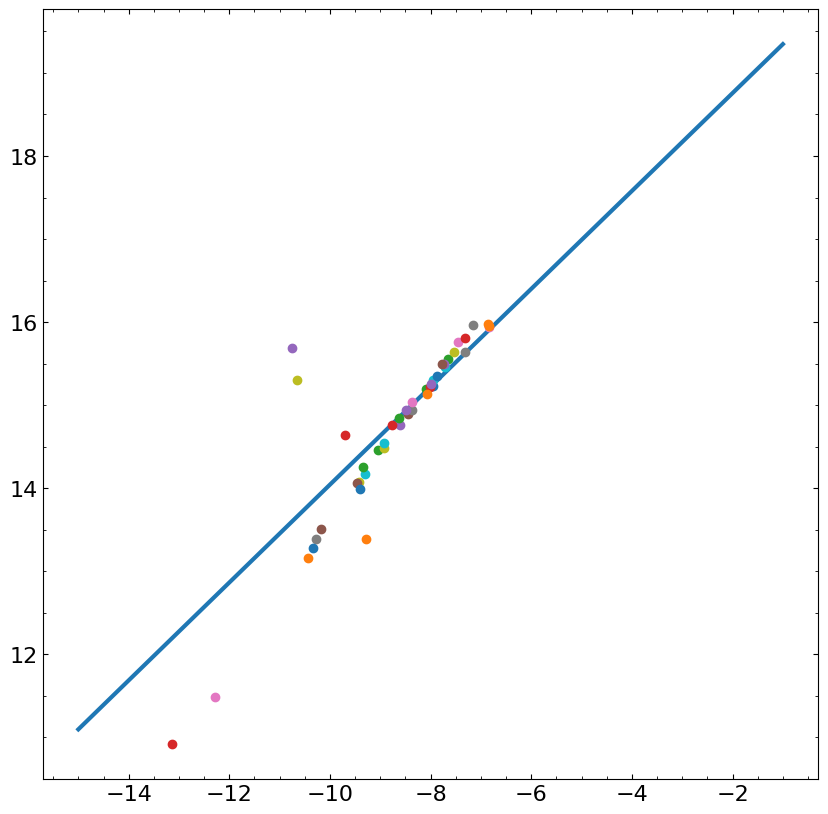

In [71]:
inst_mags = [mag['inst_mag'] for mag in mags]
sky_mags = [mag['sky_mag'] for mag in mags]

p = np.polyfit(inst_mags, sky_mags, deg= 1)
x = np.arange(-15, 0)
y = p[0]*x + p[1]
# y = x + 23.2
print(p[0], p[1])

plt.plot(x, y)
for star in mags[::2]:
    plt.errorbar(star['inst_mag'], star['sky_mag'], marker  = 'o', linestyle ='')
plt.show()